# Imports and data loading

In [1]:
import bayesian_multitarget_latent_factors as bmlf
import arviz as az

doInference = False # if False just do the analysis of the idata.nc file

data_dic, test_xr = \
bmlf.dataset_generator(215, n_train_samples=150, )

# Generate inference data netCDF file

In [2]:
if doInference:
    idata = \
    bmlf.sample_from_posterior(data_dic, 1997, output_dir='./01_bspline_generated_example', X_test = test_xr['X_test'].values)
    
    az.to_netcdf(idata, './01_bspline_generated_example/idata.nc')

    raise Exception("Stop the execution here!")

# Explore the inference data file

In [3]:
idata = az.from_netcdf("./01_bspline_generated_example/idata.nc")

In [4]:
Varimax_res_xr = bmlf.Varimax_RSP(idata)

Rotated sample 0
Rotated sample 500
Rotated sample 1000
Rotated sample 1500
Rotated sample 2000
Rotated sample 2500
Rotated sample 3000
Rotated sample 3500
Starting iteration number 0
	 Previous objective fun =	inf
	 New objective fun =		134892.289
Starting iteration number 1
	 Previous objective fun =	134892.289
	 New objective fun =		28934.319
Starting iteration number 2
	 Previous objective fun =	28934.319
	 New objective fun =		28664.334
Starting iteration number 3
	 Previous objective fun =	28664.334
	 New objective fun =		28648.400
Starting iteration number 4
	 Previous objective fun =	28648.400
	 New objective fun =		28642.781
Starting iteration number 5


In [5]:
import matplotlib as _mpl
import matplotlib.pyplot as _plt
import seaborn as _sns
import pandas as _pd
import xarray as _xr
import numpy as _np

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual

In [6]:
color_dict = {"Tyrian purple":"5f0f40","Carmine":"9a031e",
              "UT orange":"fb8b24","Spanish orange":"e36414",
              "Midnight green":"0f4c5c","Olivine":"8cb369",
              "Flax":"f4e285","Sandy brown":"f4a259",
              "Viridian":"5b8e7d","Bittersweet shimmer":"bc4b51"}
color_dict = \
{
    key: '#'+color_dict[key]
    for key in color_dict
}

In [7]:
def show_palette(color_dict):
    fig, ax = _plt.subplots(figsize=(20, 2))
    for i, (name, hex) in enumerate(color_dict.items()):
        aux = ax.add_patch(_plt.Rectangle((i, 0), 1, 1, color=hex))
        """
        aux = ax.text(i + 0.5, 0.5, name, va='center', ha='center', fontsize=10,
                      color=_mpl.colors.to_hex(
                          _mpl.colors.hsv_to_rgb( _np.mod(_np.abs(_np.array([-0.5,1,1]) - _mpl.colors.rgb_to_hsv(_mpl.colors.hex2color(color_dict[name])) ) , 1) )
                      )
                     )
        """
        aux = ax.text(i + 0.5, 0.5, name, va='center', ha='center', fontsize=10,
                      color=_mpl.colors.to_hex(
                          _np.array([1,1,1]) - _np.array([1,1,1])*( _mpl.colors.rgb_to_hsv(_mpl.colors.hex2color(color_dict[name]))[2] > 0.5 )
                      )
                     )
        
    
    aux = ax.set_xlim(0, len(color_dict))
    aux = ax.set_ylim(0, 1)
    aux = ax.axis('off')


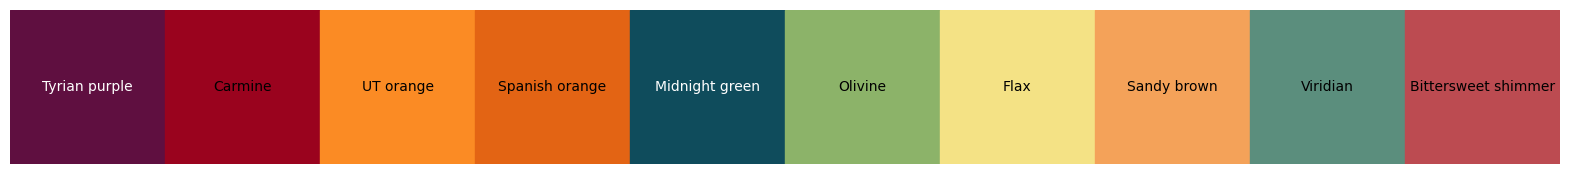

In [8]:
show_palette(color_dict)

In [9]:
def plot_Y(ax, idata, test_xr, rng_seed = 200, sample_idx = 0, target = 2, required = 'predictive', scatter = True, bootstrap = None, conditional = False):

    rng = _np.random.default_rng(rng_seed)
    
    if not target in [1,2]:
        raise ValueError("Hey!")
    
    from copy import deepcopy

    if target == 1:
        t = idata.constant_data['t1']
    else:
        t = idata.constant_data['t2']

    if not conditional:
        aux_xr = bmlf.sample_unconditional_predictive(
            idata,
            bmlf.renaming_convention( test_xr['X_test']).sel(sample_idx=[sample_idx]).values,
            rng.integers(1000000),
            bootstrap=bootstrap,
            required=required
        )[f'Y{target}'].sel(sample_idx=0)
    else:
        if target == 2:
            aux_xr = bmlf.sample_conditional_predictive(
                idata,
                bmlf.renaming_convention( test_xr['X_test']).sel(sample_idx=[sample_idx]).values,
                rng.integers(1000000),
                bootstrap=bootstrap,
                Y1_test = bmlf.renaming_convention( test_xr['y1']).sel(sample_idx=[sample_idx]).values,
                required=required
            ).sel(sample_idx=0)
        else:
            aux_xr = bmlf.sample_conditional_predictive(
                idata,
                bmlf.renaming_convention( test_xr['X_test']).sel(sample_idx=[sample_idx]).values,
                rng.integers(1000000),
                bootstrap=bootstrap,
                Y2_test = bmlf.renaming_convention( test_xr['y2']).sel(sample_idx=[sample_idx]).values,
                required=required
            ).sel(sample_idx=0)
    
    if bootstrap is None:
        aux_xr = aux_xr.stack(sample = ('chain','draw')).T
    
    _sns.lineplot(
        _pd.DataFrame(
            aux_xr.values,
            columns=t
        ).melt(),
        x='variable',
        y='value',
        errorbar=('pi',90),
        color=color_dict['Viridian'],
        ax = ax
    )
    
    ax.scatter(t, bmlf.renaming_convention( test_xr[f'y{target}'] ).sel(sample_idx=sample_idx).values, 50, color_dict['Bittersweet shimmer'], )


In [10]:
def plot_Y_wrapper(rng_seed, same_sample = True, sample_ul = 0, sample_ur = 0, sample_ll = 0, sample_lr = 0, 
                   target_ul = 1, target_ur = 2, target_ll = 1, target_lr = 2,
                   req_ul = 'predictive', req_ur = 'predictive', req_ll = 'predictive', req_lr = 'predictive',
                   conditional_ul = False, conditional_ur = False, conditional_ll = True, conditional_lr = True,
                   sharey = 'col'
                  ):
    rng = _np.random.default_rng(rng_seed)
    
    fig, axs = _plt.subplots(2,2,sharey=sharey)
    
    fig.set_figheight(11)
    fig.set_figwidth(20)

    if same_sample:
        sample_ul_internal = sample_ul
        sample_ur_internal = sample_ul
        sample_ll_internal = sample_ul
        sample_lr_internal = sample_ul
    else:
        sample_ul_internal = sample_ul
        sample_ur_internal = sample_ur
        sample_ll_internal = sample_ll
        sample_lr_internal = sample_lr
    
    plot_Y(axs[0,0], idata, test_xr, bootstrap=500, rng_seed=rng.integers(1000000),
           sample_idx = sample_ul_internal, target = target_ul,
           required=req_ul, conditional=conditional_ul
          )
    
    plot_Y(axs[0,1], idata, test_xr, bootstrap=500, rng_seed=rng.integers(1000000),
           sample_idx = sample_ur_internal, target = target_ur,
           required=req_ur, conditional=conditional_ur
          )
    
    plot_Y(axs[1,0], idata, test_xr, bootstrap=500, rng_seed=rng.integers(1000000),
           sample_idx = sample_ll_internal, target = target_ll,
           required=req_ll, conditional=conditional_ll
          )
    
    plot_Y(axs[1,1], idata, test_xr, bootstrap=500, rng_seed=rng.integers(1000000),
           sample_idx = sample_lr_internal, target = target_lr,
           required=req_lr, conditional=conditional_lr
          )


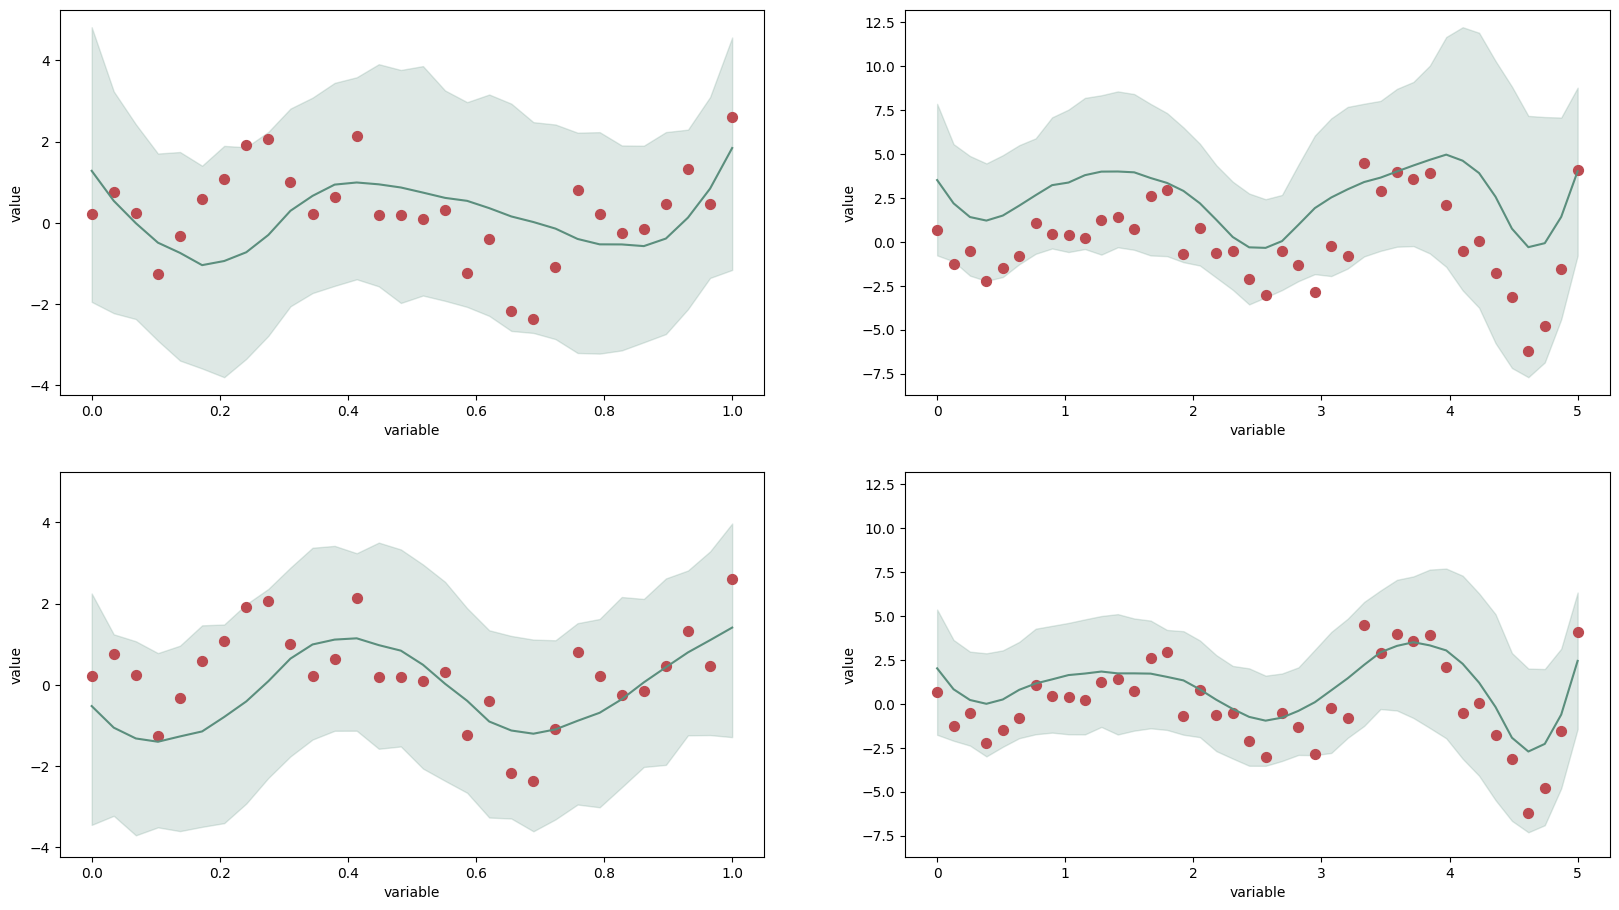

In [11]:
plot_Y_wrapper(123, sample_ul=19)

In [12]:
from ipywidgets import interactive, Layout

N = test_xr.sizes['X_test_dim_1']

interact(plot_Y_wrapper, rng_seed=widgets.IntSlider(min=1, max=500, step=1, value=123),
         sample_ul = range(N), sample_ur = range(N),
         sample_ll = range(N), sample_lr = range(N),
         target_ul = [1,2], target_ur = [1,2],
         target_ll = [1,2], target_lr = [1,2],
         req_ul = ['predictive','predictive idiosyncratic','predictive estimate'],
         req_ur = ['predictive','predictive idiosyncratic','predictive estimate'],
         req_ll = ['predictive','predictive idiosyncratic','predictive estimate'],
         req_lr = ['predictive','predictive idiosyncratic','predictive estimate'],
         sharey = ['none','row','col','all']
        )


interactive(children=(IntSlider(value=123, description='rng_seed', max=500, min=1), Checkbox(value=True, descr…

<function __main__.plot_Y_wrapper(rng_seed, same_sample=True, sample_ul=0, sample_ur=0, sample_ll=0, sample_lr=0, target_ul=1, target_ur=2, target_ll=1, target_lr=2, req_ul='predictive', req_ur='predictive', req_ll='predictive', req_lr='predictive', conditional_ul=False, conditional_ur=False, conditional_ll=True, conditional_lr=True, sharey='col')>

In [13]:
from bayesian_multitarget_latent_factors.HMC_helper import get_expected_log_likelihood

In [14]:
get_expected_log_likelihood(idata, ['y_posterior'])

-16596.05275714432

In [15]:
get_expected_log_likelihood(idata, ['y_prior'])

-20813.046864956035

In [16]:
def plot_heatmap_regression(pointwise = False, known_target = 1):
    fig, ax = _plt.subplots(1,1)
    if known_target == 1:
        unknown_target = 2
    else:
        unknown_target = 1
    fig.set_figwidth(9)
    fig.set_figheight(5)
    bmlf.get_relationship_between_targets(
        idata, known_target=known_target, pointwise=pointwise
    ).mean(dim='chain').mean(dim='draw').transpose(f'target_{known_target}_dim_idx',f'target_{unknown_target}_dim_idx').plot(ax=ax)

In [17]:
interact(plot_heatmap_regression, pointwise = False, known_target = [1,2])

interactive(children=(Checkbox(value=False, description='pointwise'), Dropdown(description='known_target', opt…

<function __main__.plot_heatmap_regression(pointwise=False, known_target=1)>

In [18]:
def plot_regression_by_PCA(pointwise = False, known_target = 1):
    
    n_components = 3
    
    from sklearn.decomposition import PCA
    
    def average_scores_for_heatmap(scores_xr, PC_idx, axis_1_final_len = 21):
        """
    
        """
        import numpy as np
        def _moving_average_2d(arr, window_size, axis=0):
            """
            Compute the moving average along one axis of a 2D numpy array.
            
            Parameters:
            - arr: 2D numpy array.
            - window_size: The size of the moving window.
            - axis: The axis along which to compute the moving average. Default is 0.
            
            Returns:
            - A 2D numpy array containing the moving averages.
            """
            def _moving_average_1d(x, window_size):
                # Create a window for the moving average
                window = np.ones(int(window_size))/float(window_size)
                return np.convolve(x, window, 'same')
            
            return np.apply_along_axis(_moving_average_1d, axis, arr, window_size)
        
        skips = int(np.round(scores_xr.sel(PC_idx=PC_idx).values.shape[1]/(axis_1_final_len-1)))
        
        aux_list = \
        list(
            np.int32(
                np.round(
                    np.convolve(
                        np.arange(0,scores_xr.sel(PC_idx=PC_idx).values.shape[1], skips),
                        np.array([0.5,0.5])
                    )
                )
            )
        )
        
        final_result = \
        _moving_average_2d(
            scores_xr.sel(PC_idx=PC_idx).values,
            skips,
            axis=1
        )[:,aux_list]
        return(final_result)
    
    if known_target == 1:
        unknown_target = 2
    else:
        unknown_target = 1
        
    aux_xr = \
    bmlf.get_relationship_between_targets(
        idata, known_target=known_target, pointwise=pointwise
    ).stack(sample_PCA=('chain','draw',f'target_{known_target}_dim_idx'))
    
    aux = aux_xr.T.values.copy()
    
    pca = PCA(n_components=n_components)
    aux = pca.fit_transform(aux)
    
    PCA_res_xr = \
    _xr.DataArray(
        aux,
        dims = ['sample_PCA','PC_idx'],
        coords = {'sample_PCA':aux_xr.sample_PCA}
    ).unstack('sample_PCA').stack(sample = ('chain','draw')).transpose(f'target_{known_target}_dim_idx','PC_idx','sample')
    
    
    t_unknown = idata.constant_data[f't{unknown_target}']
    t_known = idata.constant_data[f't{known_target}']
    
    fig, axs = _plt.subplots(n_components, 2)
    
    fig.set_figwidth(16)
    fig.set_figheight(13)
    
    for i in range(n_components):
        axs[i,1].plot(t_unknown, pca.components_[i])
        axs[i,1].plot(t_unknown, 0.0*t_unknown, 'k--')
        _sns.heatmap(
            _pd.DataFrame(
                average_scores_for_heatmap(
                    PCA_res_xr,
                    PC_idx=i,
                    axis_1_final_len=51
                ).T,
                columns=["{:.{}f}".format(val, 2) for val in t_known]
            ),
            center=0.0,
            yticklabels=False,
            cmap = _sns.color_palette('vlag', as_cmap=True),
            ax=axs[i,0]
        )


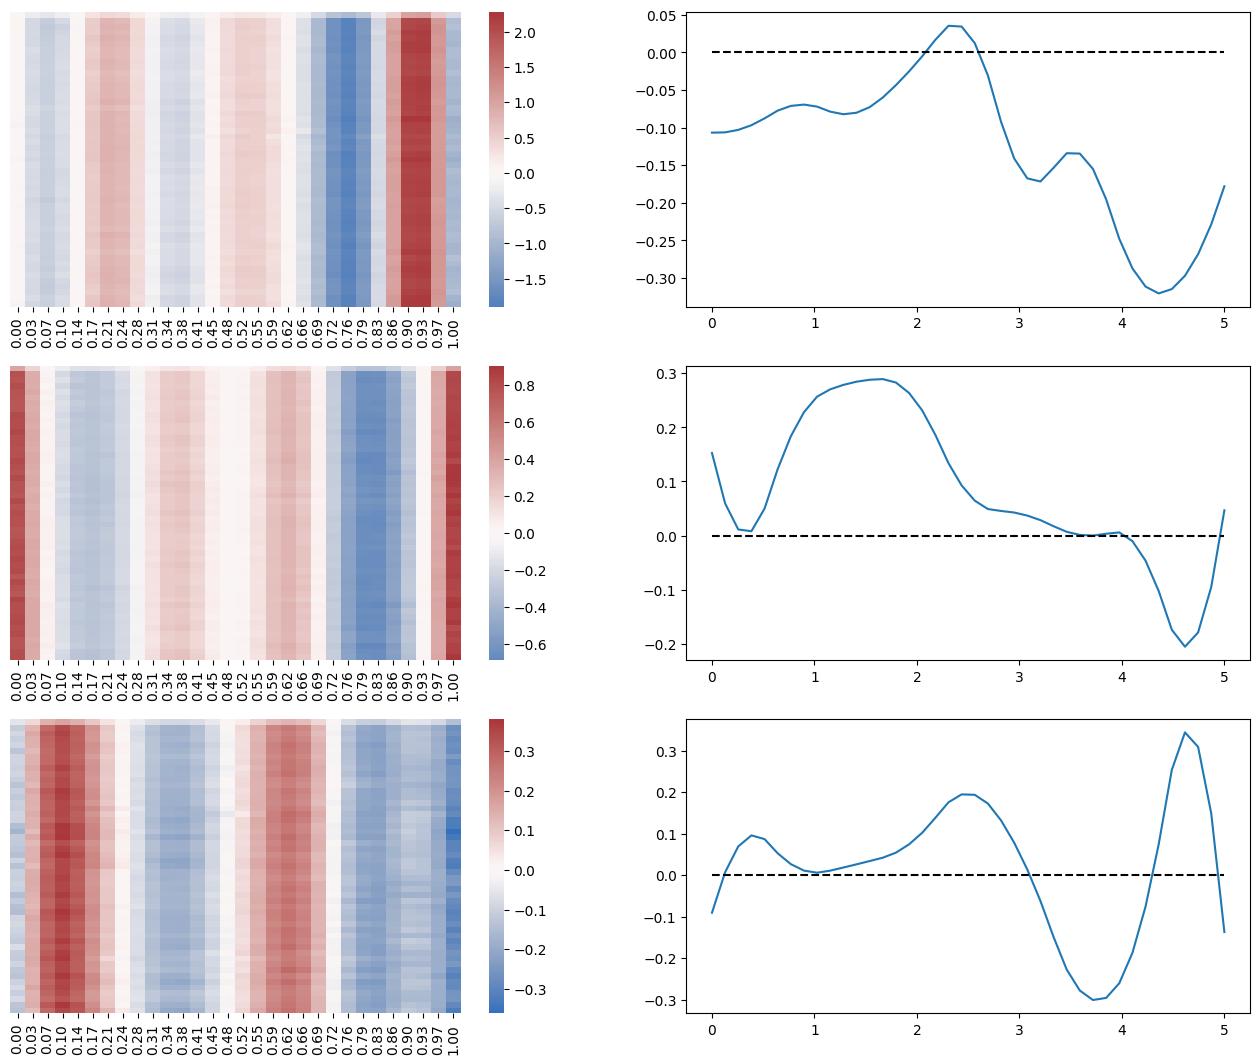

In [19]:
plot_regression_by_PCA()

In [20]:
interact(plot_regression_by_PCA, pointwise = False, known_target = [1,2])

interactive(children=(Checkbox(value=False, description='pointwise'), Dropdown(description='known_target', opt…

<function __main__.plot_regression_by_PCA(pointwise=False, known_target=1)>

In [21]:
def plot_regression_by_PCA(pointwise = False, known_target = 1):
    
    n_components = 3
    
    from sklearn.decomposition import PCA
    
    if known_target == 1:
        unknown_target = 2
    else:
        unknown_target = 1
        
    aux_xr = \
    bmlf.get_relationship_between_targets(
        idata, known_target=known_target, pointwise=pointwise
    ).stack(sample_PCA=('chain','draw',f'target_{known_target}_dim_idx'))
    
    aux = aux_xr.T.values.copy()
    
    pca = PCA(n_components=n_components)
    aux = pca.fit_transform(aux)
    
    PCA_res_xr = \
    _xr.DataArray(
        aux,
        dims = ['sample_PCA','PC_idx'],
        coords = {'sample_PCA':aux_xr.sample_PCA}
    ).unstack('sample_PCA').stack(sample = ('chain','draw')).transpose(f'target_{known_target}_dim_idx','PC_idx','sample')
    
    
    t_unknown = idata.constant_data[f't{unknown_target}']
    t_known = idata.constant_data[f't{known_target}']
    
    fig, axs = _plt.subplots(n_components, 2)
    
    fig.set_figwidth(16)
    fig.set_figheight(13)

    fig.suptitle(f'Explained variance by Principal Components: {_np.cumsum(pca.explained_variance_ratio_)}')
    fig.tight_layout()
    
    for i in range(n_components):
        axs[i,1].plot(t_unknown, pca.components_[i], c=color_dict['Carmine'])
        axs[i,1].plot(t_unknown, 0.0*t_unknown, 'k--')
        _sns.lineplot(
            _pd.DataFrame(
                PCA_res_xr.sel(PC_idx=i).T.values,
                columns=t_known
            ).melt(),
            x='variable',
            y='value',
            ax=axs[i,0],
            errorbar=('pi',90),
            color=color_dict['Carmine']
        )
        axs[i,0].plot(t_known, 0.0*t_known, 'k--')


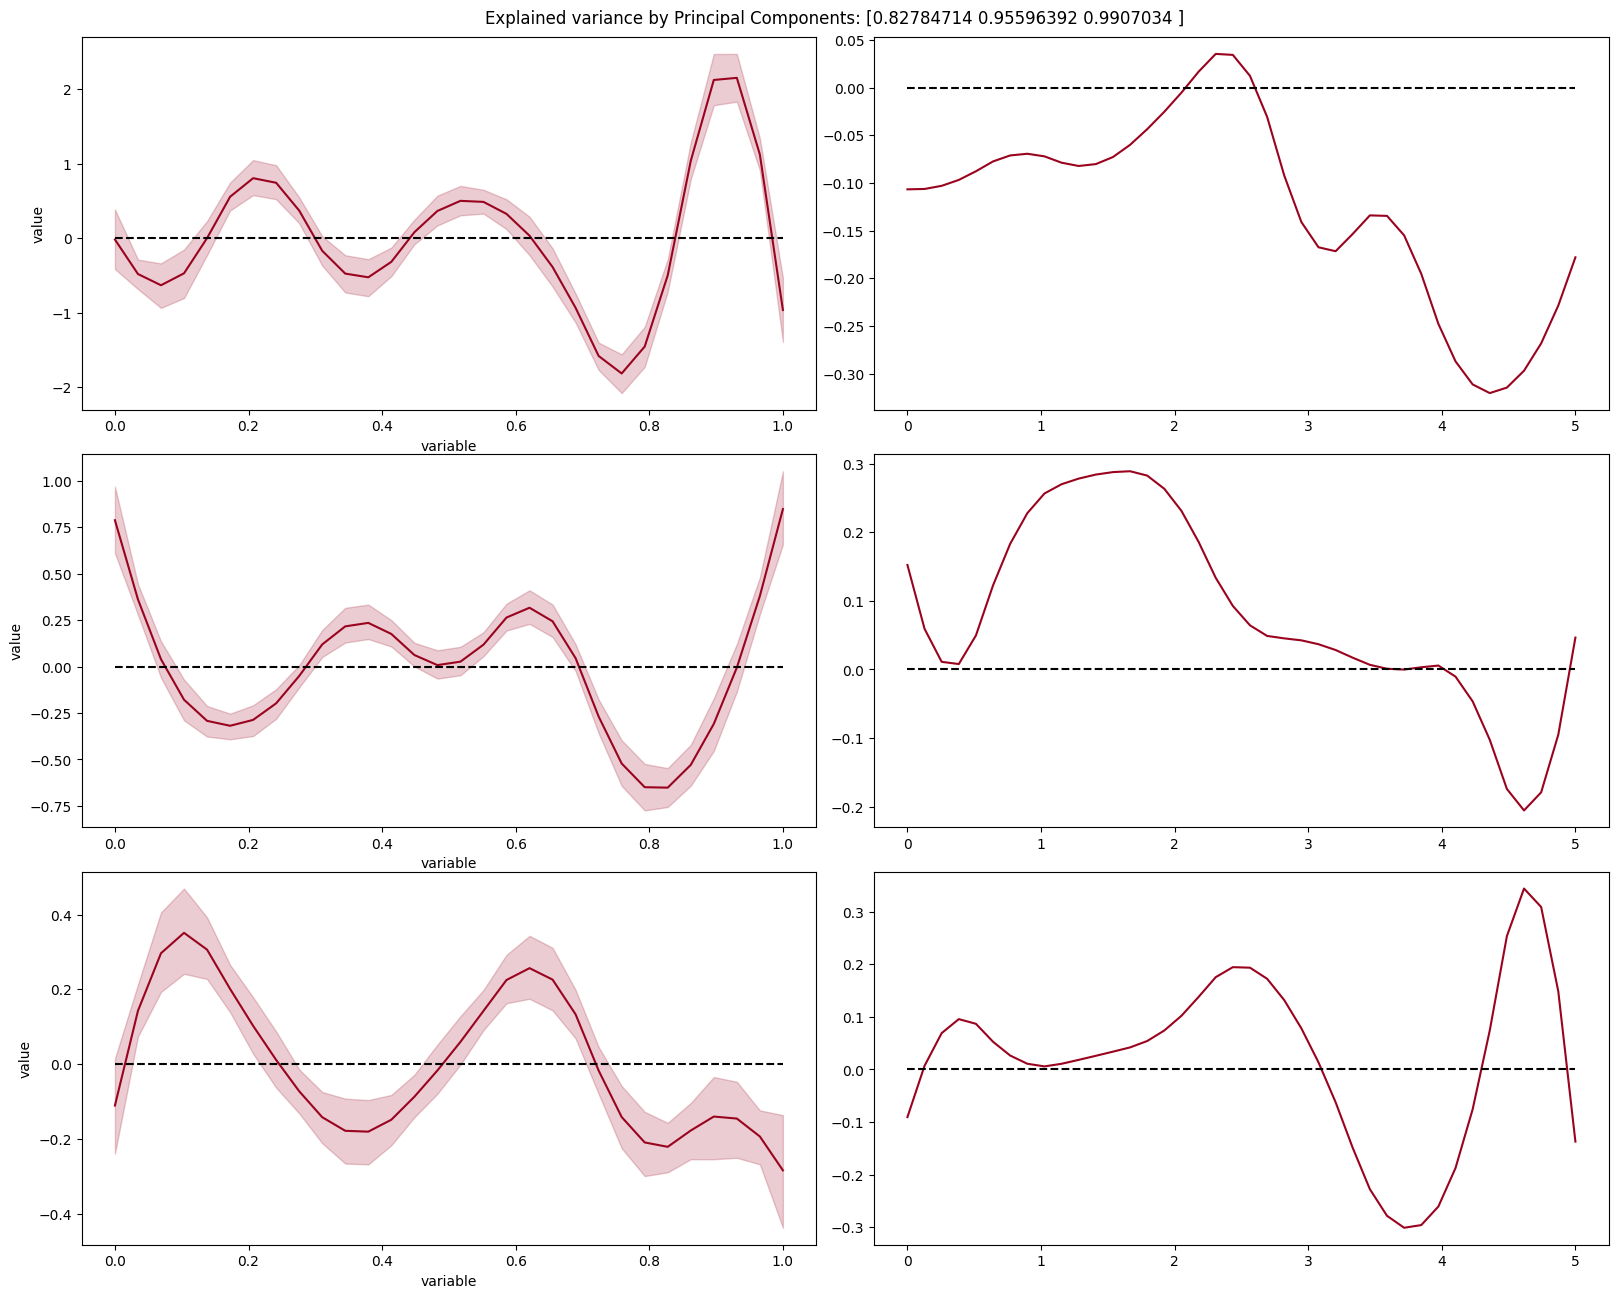

In [22]:
plot_regression_by_PCA()

In [23]:
interact(plot_regression_by_PCA, pointwise = False, known_target = [1,2])

interactive(children=(Checkbox(value=False, description='pointwise'), Dropdown(description='known_target', opt…

<function __main__.plot_regression_by_PCA(pointwise=False, known_target=1)>

In [24]:
Varimax_res_xr

<xarray.Dataset>
Dimensions:           (chain: 4, draw: 1000, latent_factor_idx: 4,
                       latent_factor_idx_bis: 4, basis_fun_branch_1_idx: 10,
                       basis_fun_branch_2_idx: 12, target_1_dim_idx: 30,
                       target_2_dim_idx: 40, covariate_idx: 5)
Coordinates:
  * chain             (chain) int64 0 1 2 3
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * target_1_dim_idx  (target_1_dim_idx) int64 0 1 2 3 4 5 ... 24 25 26 27 28 29
  * target_2_dim_idx  (target_2_dim_idx) int64 0 1 2 3 4 5 ... 34 35 36 37 38 39
  * covariate_idx     (covariate_idx) int64 0 1 2 3 4
Dimensions without coordinates: latent_factor_idx, latent_factor_idx_bis,
                                basis_fun_branch_1_idx, basis_fun_branch_2_idx
Data variables:
    R                 (chain, draw, latent_factor_idx, latent_factor_idx_bis) float64 ...
    S                 (chain, draw, latent_factor_idx) float64 1.0 -1.0 ... 1.0
    P                 (chain, draw, latent_factor_idx, latent_factor_idx_bis) float64 ...
    Λ1                (chain, draw, basis_fun_branch_1_idx, latent_factor_idx) float64 ...
    Λ2                (chain, draw, basis_fun_branch_2_idx, latent_factor_idx) float64 ...
    B1Λ1              (chain, draw, target_1_dim_idx, latent_factor_idx) float64 ...
    B2Λ2              (chain, draw, target_2_dim_idx, latent_factor_idx) float64 ...
    β                 (chain, draw, latent_factor_idx, covariate_idx) float64 ...

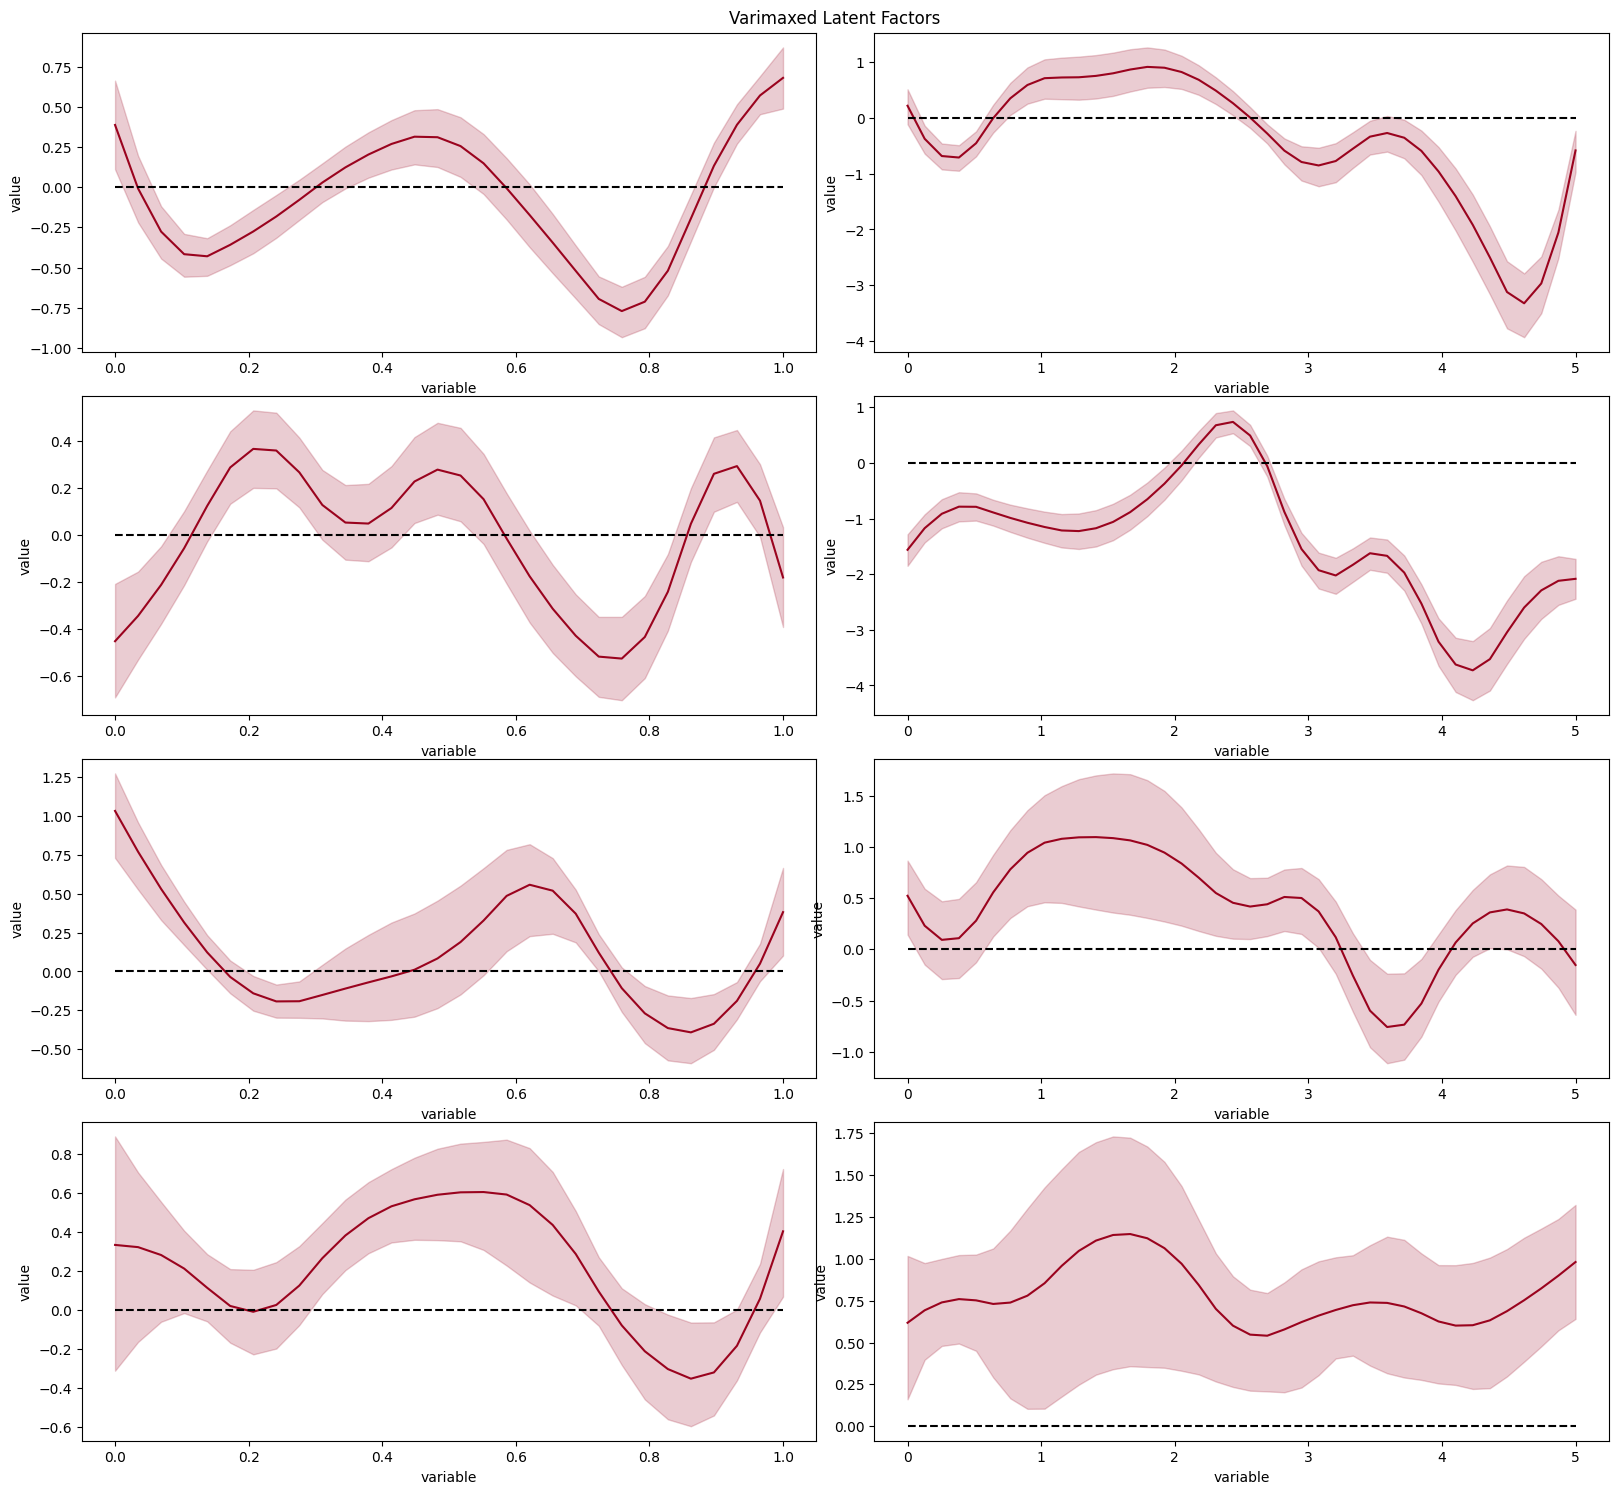

In [25]:
fig, axs = _plt.subplots(idata.constant_data['k'].values[0], 2)

fig.set_figwidth(16)
fig.set_figheight(15)

fig.suptitle('Varimaxed Latent Factors')
fig.tight_layout()

for k in range(idata.constant_data['k'].values[0]):
    _sns.lineplot(
        _pd.DataFrame(
            Varimax_res_xr['B1Λ1'].stack(sample=('chain','draw')).sel(latent_factor_idx=k).T.values,
            columns=idata.constant_data['t1']
        ).melt(),
        x='variable',
        y='value',
        ax=axs[k,0],
        errorbar=('pi',90),
        color=color_dict['Carmine']
    )
    axs[k,0].plot(idata.constant_data['t1'], 0.0*idata.constant_data['t1'], 'k--')
    _sns.lineplot(
        _pd.DataFrame(
            Varimax_res_xr['B2Λ2'].stack(sample=('chain','draw')).sel(latent_factor_idx=k).T.values,
            columns=idata.constant_data['t2']
        ).melt(),
        x='variable',
        y='value',
        ax=axs[k,1],
        errorbar=('pi',90),
        color=color_dict['Carmine']
    )
    axs[k,1].plot(idata.constant_data['t2'], 0.0*idata.constant_data['t2'], 'k--')


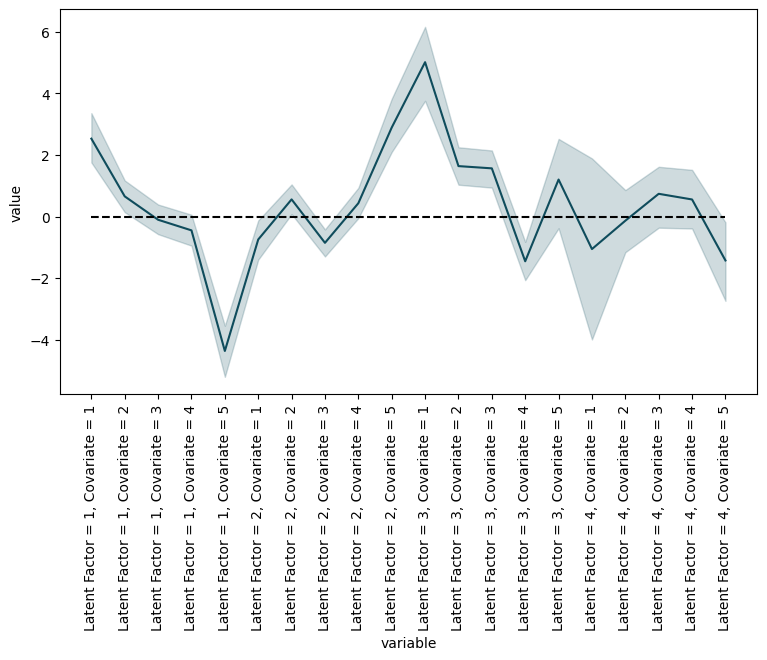

In [31]:
Varimax_res_xr['β'].stack(sample=('chain','draw'),variables=('latent_factor_idx','covariate_idx'))

fig, ax = _plt.subplots(1,1)

fig.set_figwidth(9)
fig.set_figheight(5)


_sns.lineplot(
    _pd.DataFrame(
        Varimax_res_xr['β'].stack(sample=('chain','draw'),variables=('latent_factor_idx','covariate_idx')).values,
        columns=['Latent Factor = ' + str(val[0]+1) + ', Covariate = ' + str(val[1]+1) for val in Varimax_res_xr['β'].stack(sample=('chain','draw'),variables=('latent_factor_idx','covariate_idx')).indexes['variables']]
    ).melt(),
    x='variable',
    y='value',
    errorbar=('pi',90),
    color=color_dict['Midnight green'],
    ax=ax
)

ax.plot([0,idata.constant_data['k'].values[0]*idata.constant_data['r'].values[0]-1], [0,0], 'k--')

ax.tick_params(axis='x', rotation=90)